# Использование бустинга в DMF. Разные гиперпараметры

In [5]:
import numpy as np
from copy import copy
import pandas as pd
from tqdm.auto import tqdm

from scipy.integrate import quad
from scipy.stats import genextreme

from statsmodels.discrete.discrete_model import MNLogit
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import LinearSVR
from statsmodels.regression.linear_model import OLS
from sklearn.neighbors import KNeighborsRegressor

from catboost import CatBoostClassifier

from sklearn.model_selection import cross_validate, LeaveOneOut, KFold
from sklearn.metrics import roc_auc_score, accuracy_score

from IPython.display import clear_output
import matplotlib.pyplot as plt 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 8

import warnings
warnings.filterwarnings('ignore')

## Подготовка

### Гумбель

In [6]:
beta_spend = np.array([1, 0.1, 0.0001, 1])
betas = np.array([[0.1, 0.000025, 0.3, 0.01],
                  [0.2, 0.000015, 0.2, 0.015],
                  [3, -0.00002, 0.5, -0.02]])

In [7]:
def generate_sample1(n, betas=betas, beta_spend=beta_spend, verbose=False):
    
    ### Регрессоры
    x0 = np.ones(shape=n)
    x1 = np.exp(np.random.normal(loc=10, scale=0.7, size=n))
    x2 = np.random.poisson(lam=3, size=n)
    x2[x2 > 5] = 5
    x3 = np.round(np.random.uniform(low=20, high=100, size=n))
    x4 = np.random.poisson(lam=3, size=n)
    x4[x4 > 5] = 5
    df = pd.DataFrame(zip(x0, x1, x2, x3, x4),
                      columns=['const', 'income', 'health', 'age', 'drive'])
    
    ### Линейные индексы
    eps = genextreme.rvs(c=0, size=(n, 3))
    y_li = df[['const', 'income', 'health', 'age']] @ betas.T
    df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']] = y_li + eps
    df['transport'] = np.argmax(np.array(df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']]), axis=1)

    if verbose:
        print(df.transport.value_counts())
    
    ### Расходы
    rho = np.array([0.64, -0.25, 0.14])
    mevd, __ = quad(lambda x: genextreme.pdf(x, c=0) * x, -100, 100)
    m2evd, __ = quad(lambda x: genextreme.pdf(x, c=0) * x ** 2, -100, 100)
    vevd = m2evd - mevd ** 2
    vevd_rho = np.sum(vevd * rho ** 2)
    adj = np.sqrt(6) / np.pi
    sigma = 4
    
    eps_spend = sigma * adj * (eps - mevd) @ rho + \
                np.random.normal(size=n, loc=0, scale=np.sqrt(sigma ** 2 - (sigma * adj * np.sqrt(vevd_rho) ** 2)))

    spend_li = df[['const', 'age', 'income', 'drive']] @ beta_spend.T
    df['spend'] = spend_li + eps_spend
    
    df.loc[df['transport'] != 0, 'spend'] = np.nan
    
    return df

In [8]:
def calc_coef_metrics(ests, true, model_name):
    return [model_name] + list(np.sqrt(np.mean((np.array(ests) - true) ** 2, axis=0))) + \
           list(100 * np.mean(np.abs(np.array(ests) - true) / true, axis=0))

def calc_class_metrics(scores, model_name):
    return [model_name] + list(np.mean(scores, axis=0))


### Многомерное нормальное

In [9]:
mu = np.array([0, 0, 0, 0])

cov = np.array([[1   , 0.5 , -0.2, 0.1 ],
                [0.5 , 1   , 0.25, -0.1],
                [-0.2, 0.25, 1   , 0.7 ],
                [0.1 , -0.1, 0.7 , 1   ]])

np.random.multivariate_normal(mean=mu, cov=cov, size=1000)

array([[-1.45206952, -0.93120404,  0.21226216,  0.25273917],
       [-0.41051015,  1.4475736 , -0.13113773, -0.7118186 ],
       [-0.58139681, -0.72107776,  1.37309482,  1.53563704],
       ...,
       [ 0.66493743,  0.06074358, -0.71245419, -0.55017408],
       [ 0.60505047,  0.721411  , -0.88653091, -1.03199916],
       [-1.79462533, -0.97659186,  0.71112438,  1.60613677]])

In [10]:
def generate_sample2(n, betas=betas, beta_spend=beta_spend, verbose=False):
    
    ### Регрессоры
    x0 = np.ones(shape=n)
    x1 = np.exp(np.random.normal(loc=10, scale=0.7, size=n))
    x2 = np.random.poisson(lam=3, size=n)
    x2[x2 > 5] = 5
    x3 = np.round(np.random.uniform(low=20, high=100, size=n))
    x4 = np.random.poisson(lam=3, size=n)
    x4[x4 > 5] = 5
    df = pd.DataFrame(zip(x0, x1, x2, x3, x4),
                      columns=['const', 'income', 'health', 'age', 'drive'])
    
    ### Линейные индексы
    all_eps = np.random.multivariate_normal(mean=mu, cov=cov, size=n)
    eps = all_eps[:, :3]
    eps_spend = all_eps[:, 3]
    y_li = df[['const', 'income', 'health', 'age']] @ betas.T
    df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']] = y_li + eps
    df['transport'] = np.argmax(np.array(df[['y_star_Car', 'y_star_Taxi', 'y_star_Public']]), axis=1)

    if verbose:
        print(df.transport.value_counts())
    
    ### Расходы
    spend_li = df[['const', 'age', 'income', 'drive']] @ beta_spend.T
    df['spend'] = spend_li + eps_spend
    
    df.loc[df['transport'] != 0, 'spend'] = np.nan
    
    return df

## Симуляции 5. Как зависят RMSE и MAPE от сложности бустинга при разных n

### Полиномы (подобранные на кросс-валидации по 10 фолдам)

### Ошибки из многомерного нормального

In [11]:
def simulate2(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    underfit = []
    overfit = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample2(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=4)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]

        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
        
        ### Недообученный бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=3, max_depth=1, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=4)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        underfit.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
        ### Переобученный бустинг
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=300, max_depth=6, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=4)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        overfit.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, underfit, overfit
        

In [23]:
np.random.seed(999)

n_sizes =  np.arange(1000, 10100, 100)
n_simulations = 50
ols_results1 = []
dmf_results1 = []
ml_results1 = []
underfit_results1 = []
overfit_results1 = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, under_coefs, over_coefs = simulate2(n_simulations, n_size)
    ols_results1.append(calc_coef_metrics(ols_coefs, beta_spend, model_name=n_size))
    dmf_results1.append(calc_coef_metrics(dmf_coefs, beta_spend, model_name=n_size))
    ml_results1.append(calc_coef_metrics(ml_coefs, beta_spend, model_name=n_size))
    underfit_results1.append(calc_coef_metrics(under_coefs, beta_spend, model_name=n_size))
    overfit_results1.append(calc_coef_metrics(over_coefs, beta_spend, model_name=n_size))
    
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


In [24]:
# ! mkdir fitted_boost/

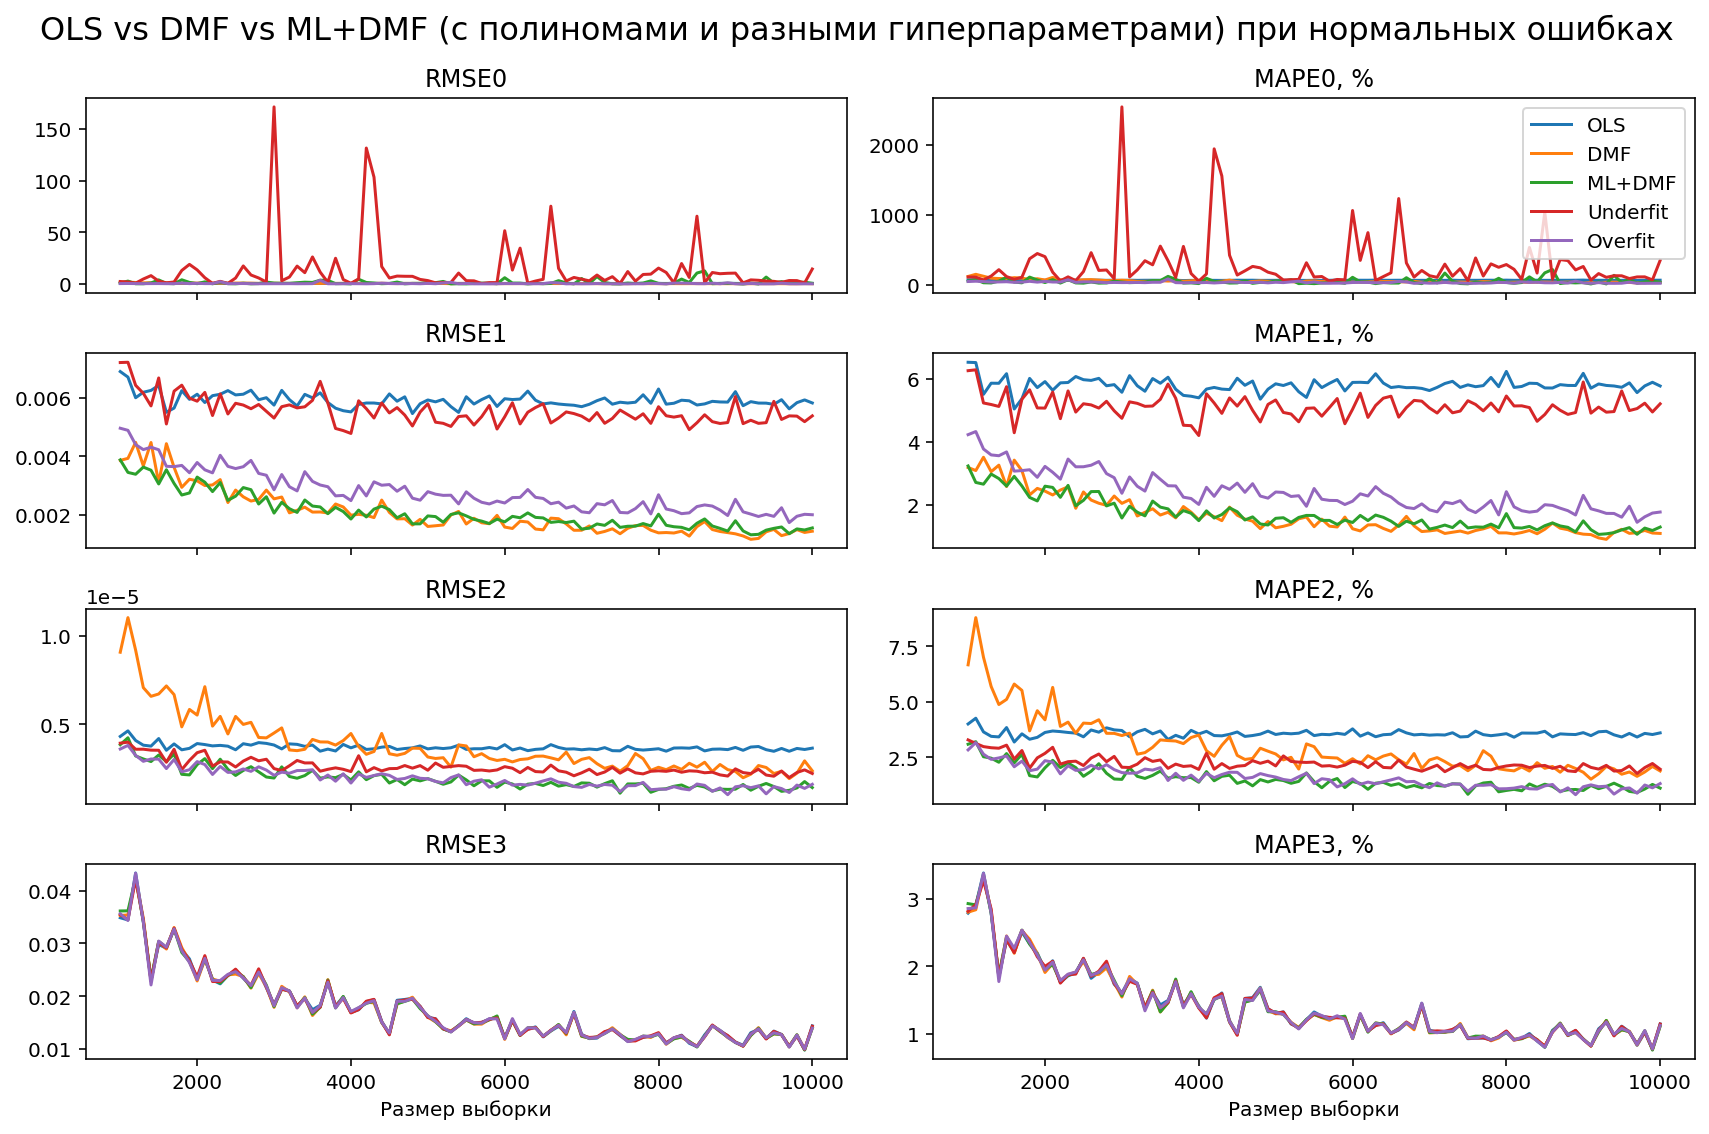

In [25]:
fig, axs = plt.subplots(4, 2, sharex=True)
fig.suptitle("OLS vs DMF vs ML+DMF (с полиномами и разными гиперпараметрами) при нормальных ошибках", fontsize=16)

for i in range(4):
    axs[i, 0].set_title(f"RMSE{i}")
    axs[i, 0].plot(np.array(ols_results1)[:, 0], np.array(ols_results1)[:, i+1], label='OLS')
    axs[i, 0].plot(np.array(dmf_results1)[:, 0], np.array(dmf_results1)[:, i+1], label='DMF')
    axs[i, 0].plot(np.array(dmf_results1)[:, 0], np.array(ml_results1)[:, i+1], label='ML+DMF')
    axs[i, 0].plot(np.array(underfit_results1)[:, 0], np.array(underfit_results1)[:, i+1], label='Underfit')
    axs[i, 0].plot(np.array(overfit_results1)[:, 0], np.array(overfit_results1)[:, i+1], label='Overfit')

    
for i in range(4):
    axs[i, 1].set_title(f"MAPE{i}, %")
    axs[i, 1].plot(np.array(ols_results1)[:, 0], np.array(ols_results1)[:, i+5], label='OLS')
    axs[i, 1].plot(np.array(dmf_results1)[:, 0], np.array(dmf_results1)[:, i+5], label='DMF')
    axs[i, 1].plot(np.array(dmf_results1)[:, 0], np.array(ml_results1)[:, i+5], label='ML+DMF')
    axs[i, 1].plot(np.array(underfit_results1)[:, 0], np.array(underfit_results1)[:, i+5], label='Underfit')
    axs[i, 1].plot(np.array(overfit_results1)[:, 0], np.array(overfit_results1)[:, i+5], label='Overfit')
    if not i:
        axs[i, 1].legend()
    
axs[3, 0].set_xlabel('Размер выборки')
axs[3, 1].set_xlabel('Размер выборки')
plt.tight_layout()
plt.savefig('fitted_boost/mnorm_different_fits.pdf', dpi=200);

### Ошибки из Гумбеля

In [26]:
def simulate1(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    underfit = []
    overfit = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample1(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=4)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]

        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
        
        ### Недообученный бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=3, max_depth=1, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=4)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        underfit.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
        ### Переобученный бустинг
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=300, max_depth=6, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
        ## Полиномы вероятностей
        # Подбираем лучший по LOO-CV (по RMSE)
        ks = np.arange(1, 7)
        all_rmses = []
        for k in ks:
            # генерируем степени вероятностей
            for i in range(1, k+1):
                df[f'proba0^{i}'] = prob_boost[:, 0] ** i
                df[f'proba1^{i}'] = prob_boost[:, 1] ** i
                df[f'proba2^{i}'] = prob_boost[:, 2] ** i
            needed_columns = ['age', 'income', 'drive'] \
                           + [f'proba{category}^{power}' for category in [0, 1, 2] 
                                                         for power in range(1, i)]
            X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
            # считаем RMSE по KFold
            mse_for_k = []
            kf = KFold(n_splits=4)
            for train, test in kf.split(X, y):
                X_train, y_train = X.iloc[train], y.iloc[train]
                X_test, y_test = X.iloc[test], y.iloc[test]
                
                lm = LinearRegression().fit(X_train, y_train)
                mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
            all_rmses.append(np.sqrt(np.mean(mse_for_k)))
        best_k = ks[np.argmin(all_rmses)]
        
        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        overfit.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, underfit, overfit
        

In [ ]:
np.random.seed(999)

n_sizes =  np.arange(1000, 10100, 100)
n_simulations = 50
ols_results1 = []
dmf_results1 = []
ml_results1 = []
underfit_results1 = []
overfit_results1 = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, under_coefs, over_coefs = simulate1(n_simulations, n_size)
    ols_results1.append(calc_coef_metrics(ols_coefs, beta_spend, model_name=n_size))
    dmf_results1.append(calc_coef_metrics(dmf_coefs, beta_spend, model_name=n_size))
    ml_results1.append(calc_coef_metrics(ml_coefs, beta_spend, model_name=n_size))
    underfit_results1.append(calc_coef_metrics(under_coefs, beta_spend, model_name=n_size))
    overfit_results1.append(calc_coef_metrics(over_coefs, beta_spend, model_name=n_size))
    
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

In [113]:
fig, axs = plt.subplots(4, 2, sharex=True)
fig.suptitle("OLS vs DMF vs ML+DMF (с полиномами и разными гиперпараметрами) при нормальных ошибках", fontsize=16)

for i in range(4):
    axs[i, 0].set_title(f"RMSE{i}")
    axs[i, 0].plot(np.array(ols_results1)[:, 0], np.array(ols_results1)[:, i+1], label='OLS')
    axs[i, 0].plot(np.array(dmf_results1)[:, 0], np.array(dmf_results1)[:, i+1], label='DMF')
    axs[i, 0].plot(np.array(dmf_results1)[:, 0], np.array(ml_results1)[:, i+1], label='ML+DMF')
    axs[i, 0].plot(np.array(underfit_results1)[:, 0], np.array(underfit_results1)[:, i+1], label='Underfit')
    axs[i, 0].plot(np.array(overfit_results1)[:, 0], np.array(overfit_results1)[:, i+1], label='Overfit')

    
for i in range(4):
    axs[i, 1].set_title(f"MAPE{i}, %")
    axs[i, 1].plot(np.array(ols_results1)[:, 0], np.array(ols_results1)[:, i+5], label='OLS')
    axs[i, 1].plot(np.array(dmf_results1)[:, 0], np.array(dmf_results1)[:, i+5], label='DMF')
    axs[i, 1].plot(np.array(dmf_results1)[:, 0], np.array(ml_results1)[:, i+5], label='ML+DMF')
    axs[i, 1].plot(np.array(underfit_results1)[:, 0], np.array(underfit_results1)[:, i+5], label='Underfit')
    axs[i, 1].plot(np.array(overfit_results1)[:, 0], np.array(overfit_results1)[:, i+5], label='Overfit')
    if not i:
        axs[i, 1].legend()
    
axs[3, 0].set_xlabel('Размер выборки')
axs[3, 1].set_xlabel('Размер выборки')
plt.tight_layout()
plt.savefig('fitted_boost/humbel_different_fits.pdf', dpi=200);

Текущий размер выборки (уже посчитан): 10000


### Регуляризация в мультилогите

In [37]:
def simulate3(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    l1 = []
    l3 = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample1(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### Бустинг
        ## Вероятности
        X, y = df[['income', 'health', 'age']], df['transport']
        boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
        boosting.fit(X, y)
        prob_boost = boosting.predict_proba(X)
        
#         ## Полиномы вероятностей
#         # Подбираем лучший по LOO-CV (по RMSE)
#         ks = np.arange(1, 7)
#         all_rmses = []
#         for k in ks:
#             # генерируем степени вероятностей
#             for i in range(1, k+1):
#                 df[f'proba0^{i}'] = prob_boost[:, 0] ** i
#                 df[f'proba1^{i}'] = prob_boost[:, 1] ** i
#                 df[f'proba2^{i}'] = prob_boost[:, 2] ** i
#             needed_columns = ['age', 'income', 'drive'] \
#                            + [f'proba{category}^{power}' for category in [0, 1, 2] 
#                                                          for power in range(1, i)]
#             X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
#             # считаем RMSE по KFold
#             mse_for_k = []
#             kf = KFold(n_splits=4)
#             for train, test in kf.split(X, y):
#                 X_train, y_train = X.iloc[train], y.iloc[train]
#                 X_test, y_test = X.iloc[test], y.iloc[test]
                
#                 lm = LinearRegression().fit(X_train, y_train)
#                 mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
#             all_rmses.append(np.sqrt(np.mean(mse_for_k)))

        df[f'proba0^1'] = prob_boost[:, 0] 
        df[f'proba1^1'] = prob_boost[:, 1] 
        df[f'proba2^1'] = prob_boost[:, 2]
        
        best_k = 1

        df_no_nans = df.dropna()
        
        ## Линейная модель
        needed_columns = ['age', 'income', 'drive'] \
                       + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
        dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
        ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
        ### DMF lambda=1
        ## Вероятности
        lr = MNLogit(y, X).fit_regularized(disp=0, method='l1', alpha=1.0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        l1.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### DMF lambda=3
        ## Вероятности
        lr = MNLogit(y, X).fit_regularized(disp=0, method='l1', alpha=3)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        l3.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
    return ols_coefs, dmf_coefs, ml_coefs, l1, l3 
        

In [38]:
np.random.seed(999)

n_sizes =  np.arange(1000, 10100, 100)
n_simulations = 50
ols_results3 = []
dmf_results3 = []
ml_results3 = []
l1_results3 = []
l3_results3 = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, ml_coefs, l1_coefs, l3_coefs = simulate3(n_simulations, n_size)
    ols_results3.append(calc_coef_metrics(ols_coefs, beta_spend, model_name=n_size))
    dmf_results3.append(calc_coef_metrics(dmf_coefs, beta_spend, model_name=n_size))
    ml_results3.append(calc_coef_metrics(ml_coefs, beta_spend, model_name=n_size))
    l1_results3.append(calc_coef_metrics(l1_coefs, beta_spend, model_name=n_size))
    l3_results3.append(calc_coef_metrics(l3_coefs, beta_spend, model_name=n_size))
    
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


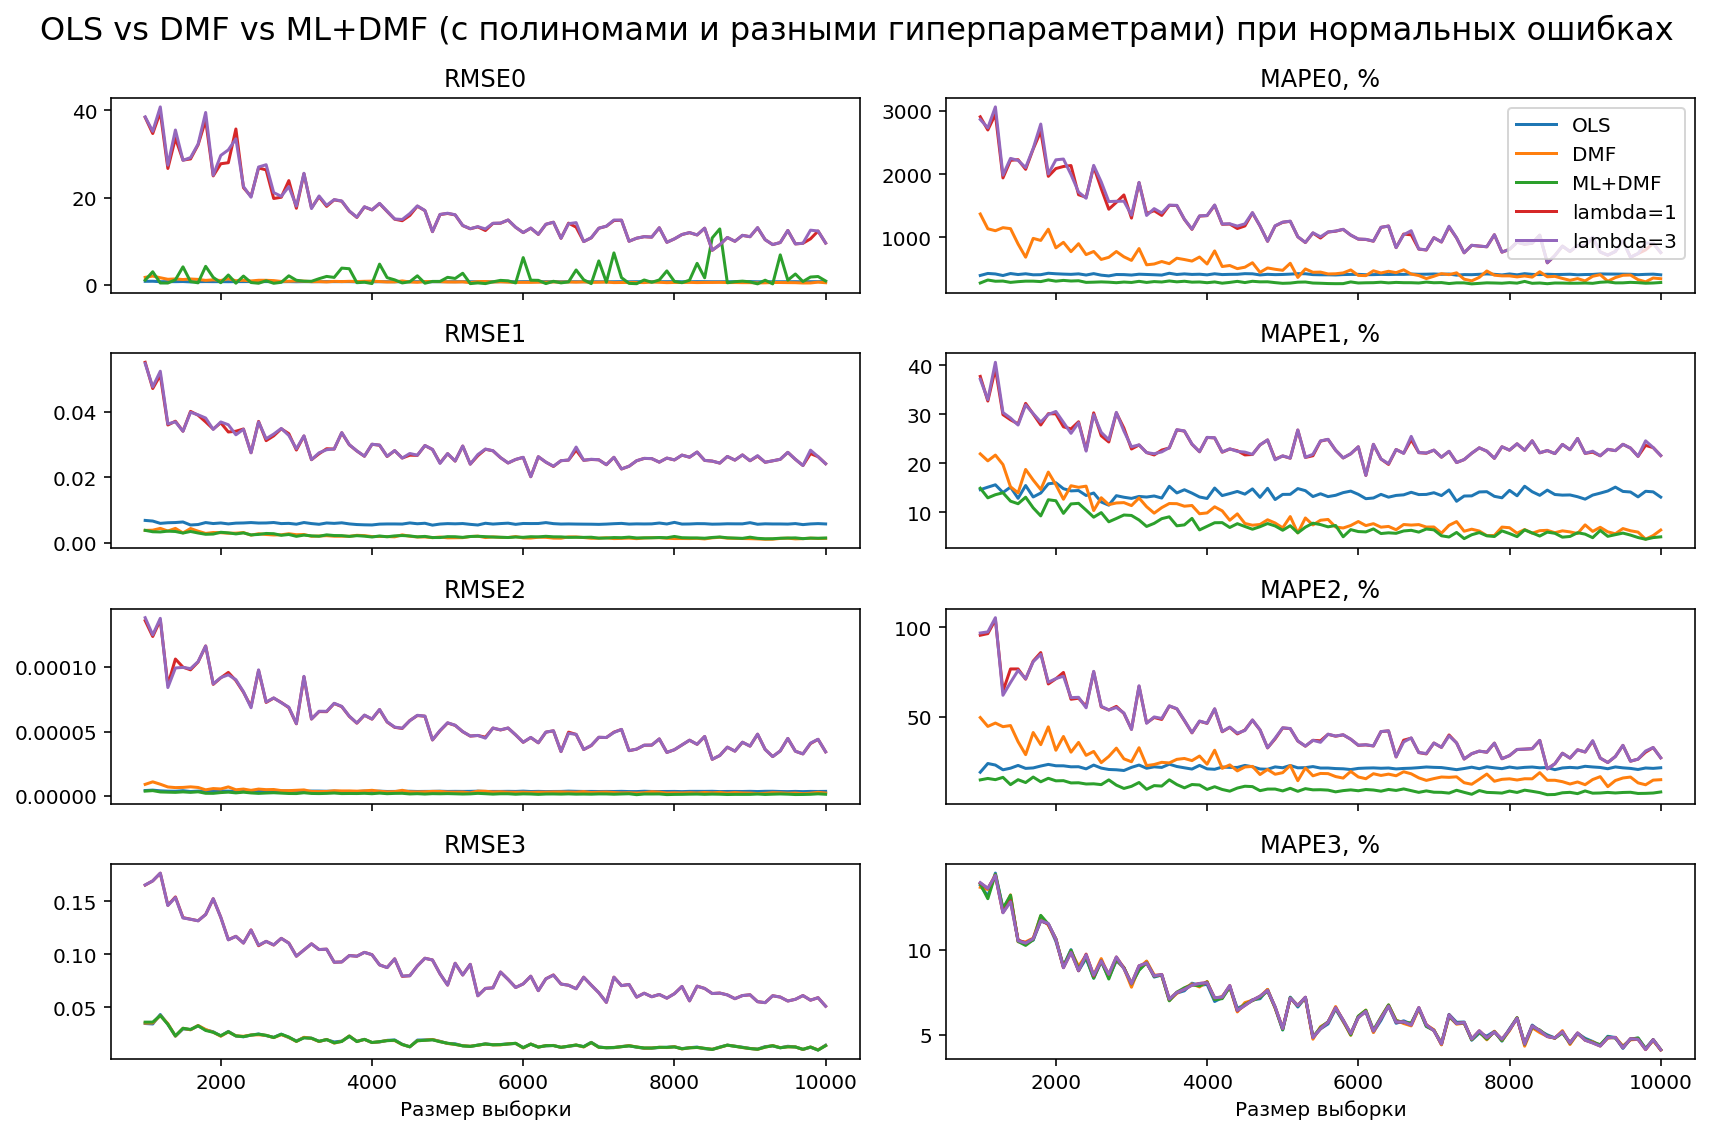

In [39]:
fig, axs = plt.subplots(4, 2, sharex=True)
fig.suptitle("OLS vs DMF vs ML+DMF (с полиномами и разными гиперпараметрами) при нормальных ошибках", fontsize=16)

for i in range(4):
    axs[i, 0].set_title(f"RMSE{i}")
    axs[i, 0].plot(np.array(ols_results1)[:, 0], np.array(ols_results1)[:, i+1], label='OLS')
    axs[i, 0].plot(np.array(dmf_results1)[:, 0], np.array(dmf_results1)[:, i+1], label='DMF')
    axs[i, 0].plot(np.array(dmf_results1)[:, 0], np.array(ml_results1)[:, i+1], label='ML+DMF')
    axs[i, 0].plot(np.array(l1_results3)[:, 0], np.array(l1_results3)[:, i+1], label='lambda=1')
    axs[i, 0].plot(np.array(l3_results3)[:, 0], np.array(l3_results3)[:, i+1], label='lambda=3')

    
for i in range(4):
    axs[i, 1].set_title(f"MAPE{i}, %")
    axs[i, 1].plot(np.array(ols_results3)[:, 0], np.array(ols_results3)[:, i+5], label='OLS')
    axs[i, 1].plot(np.array(dmf_results3)[:, 0], np.array(dmf_results3)[:, i+5], label='DMF')
    axs[i, 1].plot(np.array(dmf_results3)[:, 0], np.array(ml_results3)[:, i+5], label='ML+DMF')
    axs[i, 1].plot(np.array(l1_results3)[:, 0], np.array(l1_results3)[:, i+5], label='lambda=1')
    axs[i, 1].plot(np.array(l3_results3)[:, 0], np.array(l3_results3)[:, i+5], label='lambda=3')
    if not i:
        axs[i, 1].legend()
    
axs[3, 0].set_xlabel('Размер выборки')
axs[3, 1].set_xlabel('Размер выборки')
plt.tight_layout()
plt.savefig('fitted_boost/different_penalties_logit.pdf', dpi=200);

In [41]:
def simulate4(n_simulations, n_size):
    
    ols_coefs = []
    dmf_coefs = []
    ml_coefs = []
    l1 = []
    l3 = []
    

    for i in tqdm(range(n_simulations)):
        
        ### Генерируем данные
        df = generate_sample1(n_size)
        X, y = df[['const', 'income', 'health', 'age']], df['transport']
        df_no_nans = df.dropna()
        X_spend = df_no_nans[['age', 'income', 'drive']]
        y_spend = df_no_nans['spend']
        
        ### МНК
        lm = LinearRegression().fit(X_spend, y_spend)
        ols_coefs.append([lm.intercept_] + list(lm.coef_))
        
        ### DMF
        ## Вероятности
        lr = MNLogit(y, X).fit(disp=0)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        dmf_coefs.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
#         ### Бустинг
#         ## Вероятности
#         X, y = df[['income', 'health', 'age']], df['transport']
#         boosting = CatBoostClassifier(iterations=10, max_depth=3, verbose=0)
#         boosting.fit(X, y)
#         prob_boost = boosting.predict_proba(X)
        
#         ## Полиномы вероятностей
#         # Подбираем лучший по LOO-CV (по RMSE)
#         ks = np.arange(1, 7)
#         all_rmses = []
#         for k in ks:
#             # генерируем степени вероятностей
#             for i in range(1, k+1):
#                 df[f'proba0^{i}'] = prob_boost[:, 0] ** i
#                 df[f'proba1^{i}'] = prob_boost[:, 1] ** i
#                 df[f'proba2^{i}'] = prob_boost[:, 2] ** i
#             needed_columns = ['age', 'income', 'drive'] \
#                            + [f'proba{category}^{power}' for category in [0, 1, 2] 
#                                                          for power in range(1, i)]
#             X, y = df.dropna()[needed_columns], df.dropna()['spend']
            
#             # считаем RMSE по KFold
#             mse_for_k = []
#             kf = KFold(n_splits=4)
#             for train, test in kf.split(X, y):
#                 X_train, y_train = X.iloc[train], y.iloc[train]
#                 X_test, y_test = X.iloc[test], y.iloc[test]
                
#                 lm = LinearRegression().fit(X_train, y_train)
#                 mse_for_k.append((y_test - lm.predict(X_test)) ** 2)
                
#             all_rmses.append(np.sqrt(np.mean(mse_for_k)))

#         df[f'proba0^1'] = prob_boost[:, 0] 
#         df[f'proba1^1'] = prob_boost[:, 1] 
#         df[f'proba2^1'] = prob_boost[:, 2]
        
#         best_k = 1

#         df_no_nans = df.dropna()
        
#         ## Линейная модель
#         needed_columns = ['age', 'income', 'drive'] \
#                        + [f'proba{category}^{power}' for category in [0, 1, 2] for power in range(1, best_k+1)]
        
#         dmf_ml = LinearRegression().fit(df_no_nans[needed_columns], y_spend)
#         ml_coefs.append([dmf_ml.intercept_] + list(dmf_ml.coef_[:3]))
        
        ### DMF lambda=1
        ## Вероятности
        lr = MNLogit(y, X).fit_regularized(disp=0, method='l1', alpha=0.1)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        l1.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
        ### DMF lambda=3
        ## Вероятности
        lr = MNLogit(y, X).fit_regularized(disp=0, method='l1', alpha=0.3)
        prob_lr = lr.predict()
        
        ## Лямбды
        df['lambda1'] = -np.log(prob_lr[:, 0])
        df['lambda2'] = prob_lr[:, 1] * np.log(prob_lr[:, 1]) / (1 - prob_lr[:, 1])
        df['lambda3'] = prob_lr[:, 2] * np.log(prob_lr[:, 2]) / (1 - prob_lr[:, 2])
        df_no_nans = df.dropna()
    
        ## Линейная модель
        dmf = LinearRegression().fit(df_no_nans[['age', 'income', 'drive', 
                                                 'lambda1', 'lambda2', 'lambda3']], y_spend)
        l3.append([dmf.intercept_] + list(dmf.coef_[:3]))
        
    return ols_coefs, dmf_coefs, l1, l3 
        

In [43]:
np.random.seed(999)

n_sizes =  np.arange(1000, 10100, 100)
n_simulations = 50
ols_results3 = []
dmf_results3 = []
ml_results3 = []
l1_results3 = []
l3_results3 = []

for n_size in n_sizes:
    ols_coefs, dmf_coefs, l1_coefs, l3_coefs = simulate4(n_simulations, n_size)
    ols_results3.append(calc_coef_metrics(ols_coefs, beta_spend, model_name=n_size))
    dmf_results3.append(calc_coef_metrics(dmf_coefs, beta_spend, model_name=n_size))
    # ml_results3.append(calc_coef_metrics(ml_coefs, beta_spend, model_name=n_size))
    l1_results3.append(calc_coef_metrics(l1_coefs, beta_spend, model_name=n_size))
    l3_results3.append(calc_coef_metrics(l3_coefs, beta_spend, model_name=n_size))
    
    clear_output(wait=True)
    print('Текущий размер выборки (уже посчитан):', n_size)

Текущий размер выборки (уже посчитан): 10000


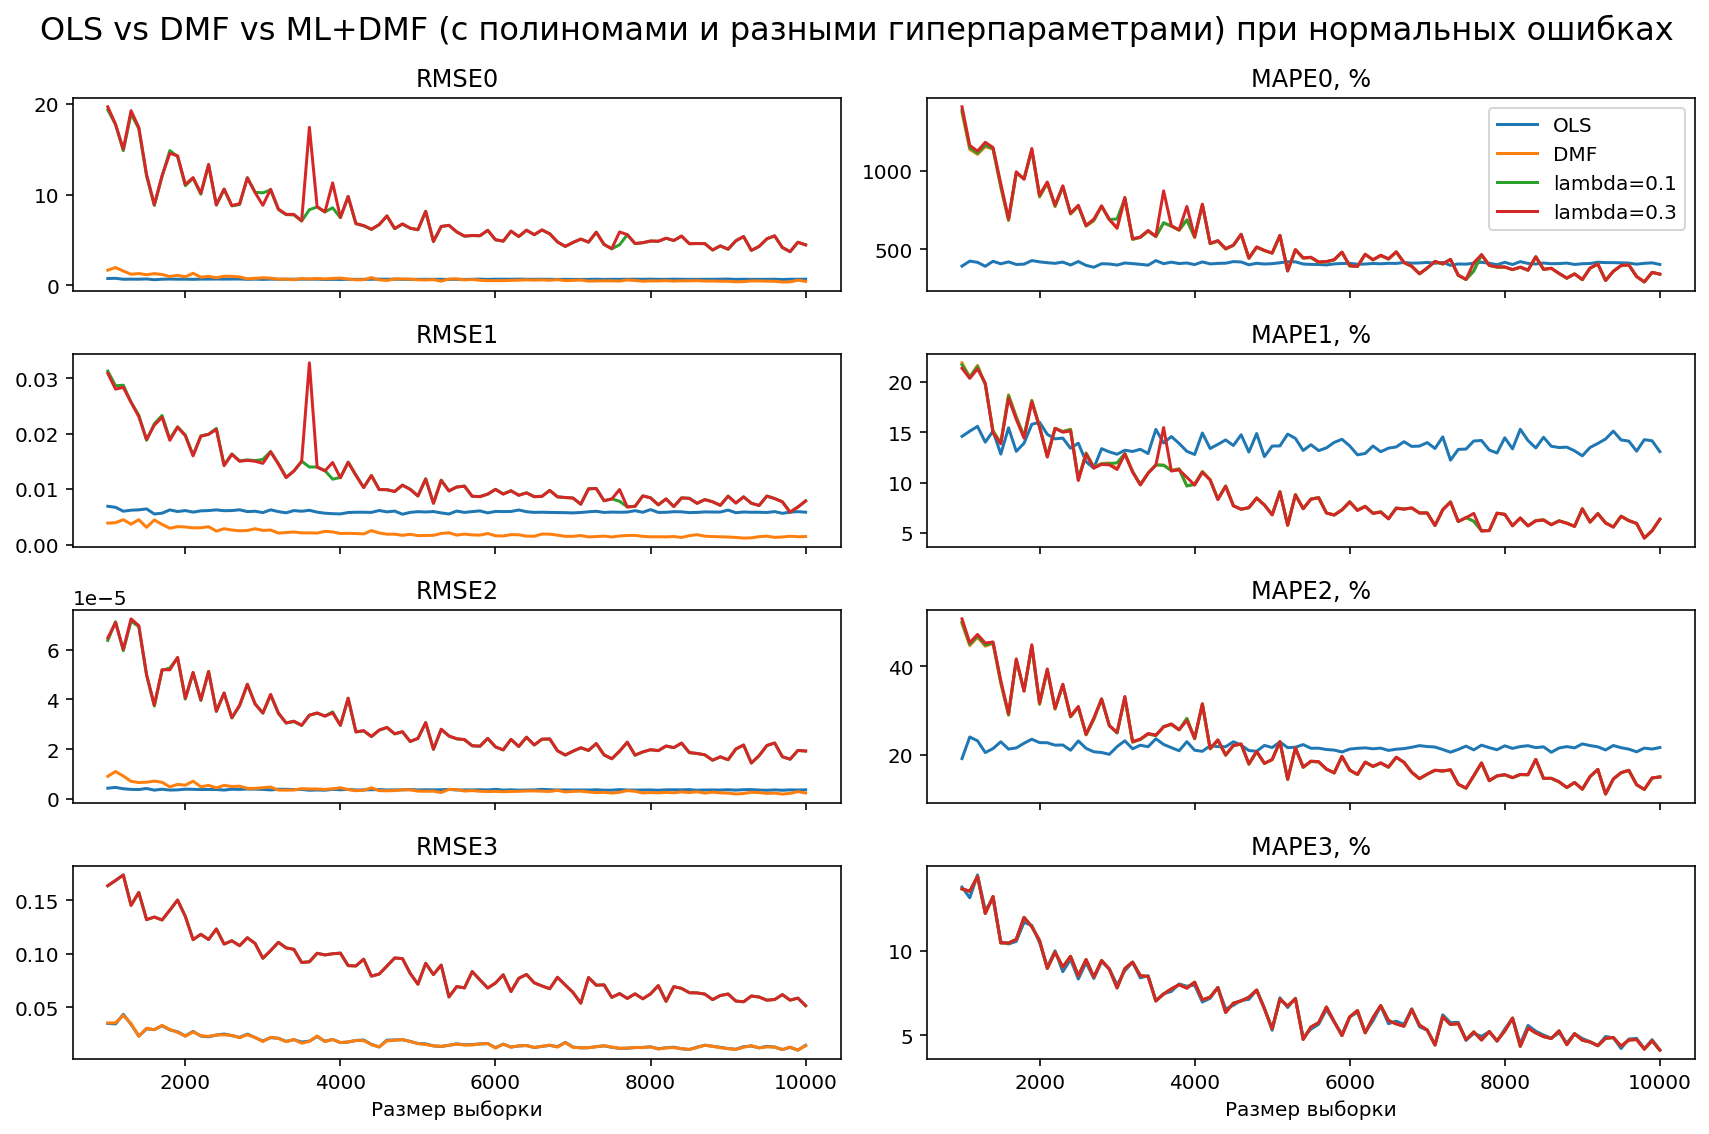

In [47]:
fig, axs = plt.subplots(4, 2, sharex=True)
fig.suptitle("OLS vs DMF vs ML+DMF (с полиномами и разными гиперпараметрами) при нормальных ошибках", fontsize=16)

for i in range(4):
    axs[i, 0].set_title(f"RMSE{i}")
    axs[i, 0].plot(np.array(ols_results1)[:, 0], np.array(ols_results1)[:, i+1], label='OLS')
    axs[i, 0].plot(np.array(dmf_results1)[:, 0], np.array(dmf_results1)[:, i+1], label='DMF')
    #axs[i, 0].plot(np.array(ml_results1)[:, 0], np.array(ml_results1)[:, i+1], label='ML+DMF')
    axs[i, 0].plot(np.array(l1_results3)[:, 0], np.array(l1_results3)[:, i+1], label='lambda=0.1')
    axs[i, 0].plot(np.array(l3_results3)[:, 0], np.array(l3_results3)[:, i+1], label='lambda=0.3')

    
for i in range(4):
    axs[i, 1].set_title(f"MAPE{i}, %")
    axs[i, 1].plot(np.array(ols_results3)[:, 0], np.array(ols_results3)[:, i+5], label='OLS')
    axs[i, 1].plot(np.array(dmf_results3)[:, 0], np.array(dmf_results3)[:, i+5], label='DMF')
    #axs[i, 1].plot(np.array(ml_results3)[:, 0], np.array(ml_results3)[:, i+5], label='ML+DMF')
    axs[i, 1].plot(np.array(l1_results3)[:, 0], np.array(l1_results3)[:, i+5], label='lambda=0.1')
    axs[i, 1].plot(np.array(l3_results3)[:, 0], np.array(l3_results3)[:, i+5], label='lambda=0.3')
    if not i:
        axs[i, 1].legend()
    
axs[3, 0].set_xlabel('Размер выборки')
axs[3, 1].set_xlabel('Размер выборки')
plt.tight_layout()
plt.savefig('fitted_boost/different_low_penalties_logit.pdf', dpi=200);